# HR Attrition

In [66]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

# CSV to database
import sqlalchemy as sqa

# Handle imbalanced data
from imblearn.combine import SMOTETomek

# Reduce data dimension for visualization
from sklearn.decomposition import PCA

# Remove less important features (Pearson correlation)
from sklearn.feature_selection import r_regression

from sklearn.preprocessing import TargetEncoder, MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
import keras

## 1. Data Preparation
Mainly intended for dashboard, ML preparation is on separate section

In [67]:
# df = pd.read_csv('data/employee_data.csv')
df = pd.read_csv('data/WA_Fn-UseC_-HR-Employee-Attrition.csv')
df.tail()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
1465,36,No,Travel_Frequently,884,Research & Development,23,2,Medical,1,2061,...,3,80,1,17,3,3,5,2,0,3
1466,39,No,Travel_Rarely,613,Research & Development,6,1,Medical,1,2062,...,1,80,1,9,5,3,7,7,1,7
1467,27,No,Travel_Rarely,155,Research & Development,4,3,Life Sciences,1,2064,...,2,80,1,6,0,3,6,2,0,3
1468,49,No,Travel_Frequently,1023,Sales,2,3,Medical,1,2065,...,4,80,0,17,3,2,9,6,0,8
1469,34,No,Travel_Rarely,628,Research & Development,8,3,Medical,1,2068,...,1,80,0,6,3,4,4,3,1,2


### 1.1. Check Missing Data
The original `employee_data.csv` from Dicoding has many missing attrition values, which is the most important one (for checking prediction accuracy, etc)

On real world scenario, it's impossible to have missing attrition values since employees that no longer work should be noticed by HR

Possible solutions:
- Solution A: use algorithm like KNN or PCA or TSNE to fill missing values (may needs data scaling)
- **Solution B (choosen)**: use alternative data from [Kaggle](https://www.kaggle.com/datasets/pavansubhasht/ibm-hr-analytics-attrition-dataset/) (no missing attrition values but need to re-add employee IDs)

In [68]:
# df.info()
df.isnull().sum()

Age                         0
Attrition                   0
BusinessTravel              0
DailyRate                   0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EmployeeCount               0
EmployeeNumber              0
EnvironmentSatisfaction     0
Gender                      0
HourlyRate                  0
JobInvolvement              0
JobLevel                    0
JobRole                     0
JobSatisfaction             0
MaritalStatus               0
MonthlyIncome               0
MonthlyRate                 0
NumCompaniesWorked          0
Over18                      0
OverTime                    0
PercentSalaryHike           0
PerformanceRating           0
RelationshipSatisfaction    0
StandardHours               0
StockOptionLevel            0
TotalWorkingYears           0
TrainingTimesLastYear       0
WorkLifeBalance             0
YearsAtCompany              0
YearsInCurrentRole          0
YearsSince

Re-add missing employee ID column (by joining both dataset)

Will be joined based on hash since there is no similar primary key on both tables (one has `EmployeeId`, the other has `EmployeeNumber` which is different)

**Note:** The original rows with missing attrition value (from Dicoding) will be marked as test data

In [69]:
# Columns to exclude from hashing (for table join operation)
# Assuming both dataframes have similar column names
skip_col = ['Attrition', 'EmployeeId', 'EmployeeNumber']
hash_col = [i for i in df.columns if i not in skip_col]

temp = pd.read_csv('data/employee_data.csv')

# Make sure to exclude index from hashing too
# Otherwise, both tables will have different hashes
temp['hash'] = pd.util.hash_pandas_object(temp[hash_col], index = False)
df['hash'] = pd.util.hash_pandas_object(df[hash_col], index = False)

temp = temp.sort_values('hash').reset_index(drop = True)
df = df.sort_values('hash').reset_index(drop = True)

# Will give output if there are still differences
df[hash_col].compare(temp[hash_col])

Empty DataFrame
Columns: []
Index: []

In [70]:
df = pd.merge(df, temp[['hash', 'EmployeeId']], on = 'hash')
df = df.drop(['hash', 'EmployeeNumber'], axis = 1)

# Mark rows with no labels (from Dicoding) as test data
df['IsTest'] = temp['Attrition'].isnull().astype('int')

# Reorder employee id column as first column
temp = [i for i in df.columns if i != 'EmployeeId']
df = df[['EmployeeId'] + temp]

df = df.sort_values('EmployeeId').reset_index(drop = True)
# Export back fixed dataframe (no missing attrition value)
df.to_csv('data/employee_data_fixed.csv', index = False)

df.tail()

,EmployeeId,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,...,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,IsTest
1465,1466,38,No,Travel_Rarely,168,Research & Development,1,3,Life Sciences,1,...,80,0,10,4,4,1,0,0,0,0
1466,1467,50,No,Travel_Rarely,813,Research & Development,17,5,Life Sciences,1,...,80,3,19,3,3,14,11,1,11,1
1467,1468,28,Yes,Travel_Rarely,1485,Research & Development,12,1,Life Sciences,1,...,80,0,1,4,2,1,1,0,0,0
1468,1469,40,No,Non-Travel,458,Research & Development,16,2,Life Sciences,1,...,80,1,6,0,3,4,2,0,0,0
1469,1470,19,Yes,Travel_Frequently,602,Sales,1,1,Technical Degree,1,...,80,0,1,5,4,0,0,0,0,0


### 1.2. Check/Convert Data Types

In [71]:
df.dtypes

EmployeeId                   int64
Age                          int64
Attrition                   object
BusinessTravel              object
DailyRate                    int64
Department                  object
DistanceFromHome             int64
Education                    int64
EducationField              object
EmployeeCount                int64
EnvironmentSatisfaction      int64
Gender                      object
HourlyRate                   int64
JobInvolvement               int64
JobLevel                     int64
JobRole                     object
JobSatisfaction              int64
MaritalStatus               object
MonthlyIncome                int64
MonthlyRate                  int64
NumCompaniesWorked           int64
Over18                      object
OverTime                    object
PercentSalaryHike            int64
PerformanceRating            int64
RelationshipSatisfaction     int64
StandardHours                int64
StockOptionLevel             int64
TotalWorkingYears   

In [72]:
# Check possible values for specific column
# Add other columns if needed
print(df['Attrition'].value_counts(dropna = False), '\n')
print(df['IsTest'].value_counts(dropna = False), '\n')
print(df['BusinessTravel'].value_counts(dropna = False))

Attrition
No     1233
Yes     237
Name: count, dtype: int64 

IsTest
0    1058
1     412
Name: count, dtype: int64 

BusinessTravel
Travel_Rarely        1043
Travel_Frequently     277
Non-Travel            150
Name: count, dtype: int64


Replace boolean and ordinal values with numeric values

In [73]:
df.replace(
    {
        'Attrition': {
            'Yes': 1,
            'No': 0
        },
        'BusinessTravel': {
            'Non-Travel': 0,
            'Travel_Rarely': 1,
            'Travel_Frequently': 2
        },
        'Over18': {
            'Y': 1,
            'N': 0
        },
        'OverTime': {
            'Yes': 1,
            'No': 0
        }
    },
    inplace = True
)

df.head()

C:\Users\Dhika\AppData\Local\Temp\VSCodePortableTemp\ipykernel_7460\763175519.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace(


,EmployeeId,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,...,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,IsTest
0,1,38,0,2,1444,Human Resources,1,4,Other,1,...,80,1,7,2,3,6,2,1,2,1
1,2,37,1,1,1141,Research & Development,11,2,Medical,1,...,80,0,15,2,1,1,0,0,0,0
2,3,51,1,1,1323,Research & Development,4,4,Life Sciences,1,...,80,3,18,2,4,10,0,2,7,0
3,4,42,0,2,555,Sales,26,3,Marketing,1,...,80,1,23,2,4,20,4,4,8,0
4,5,40,0,1,1194,Research & Development,2,4,Medical,1,...,80,3,20,2,3,5,3,0,2,1


Convert categorical values to numeric values (e.g. 0 = single, 1 = married, 2 = divorced)

Normally, label encoding is enough for dashboard, but we may use other encoder for ML model later (see comparison [here](https://www.datacamp.com/tutorial/categorical-data) and [there](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_target_encoder.html))

**Alternative:** use "pd.get_dummies" (one hot encoder) or Sklearn "TargetEncoder"

In [74]:
# Categorical columns to convert
cat_col = ['Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus']

for col in cat_col:
    # Add new numeric column (column name + N) for each categorical column
    df[col + 'N'] = pd.factorize(df[col])[0]

# Sort column names to fix newly added columns
df = df.reindex(sorted(df.columns), axis = 1)

# Place employee id at beginning and is test at the end
temp = [i for i in df.columns if i not in ['EmployeeId', 'IsTest']]
df = df[['EmployeeId'] + temp + ['IsTest']]

df.head()

,EmployeeId,Age,Attrition,BusinessTravel,DailyRate,Department,DepartmentN,DistanceFromHome,Education,EducationField,...,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,IsTest
0,1,38,0,2,1444,Human Resources,0,1,4,Other,...,80,1,7,2,3,6,2,1,2,1
1,2,37,1,1,1141,Research & Development,1,11,2,Medical,...,80,0,15,2,1,1,0,0,0,0
2,3,51,1,1,1323,Research & Development,1,4,4,Life Sciences,...,80,3,18,2,4,10,0,2,7,0
3,4,42,0,2,555,Sales,2,26,3,Marketing,...,80,1,23,2,4,20,4,4,8,0
4,5,40,0,1,1194,Research & Development,1,2,4,Medical,...,80,3,20,2,3,5,3,0,2,1


In [75]:
# # Recheck data types
# df.dtypes

### 1.3. Remove Useless Columns

In [76]:
for i in df.columns:
    if df[i].nunique() == 1:
        print(i, 'is useless (only 1 possible value)')
    if df[i].nunique() == len(df):
        print(i, 'is useless (unique values equal row length)')

EmployeeId is useless (unique values equal row length)
EmployeeCount is useless (only 1 possible value)
Over18 is useless (only 1 possible value)
StandardHours is useless (only 1 possible value)


`EmployeeId` is useless for dashboard, but still can be used for machine learning prediction (hence not removed)

In [77]:
df.drop(['EmployeeCount', 'Over18', 'StandardHours'], axis = 1, inplace = True)
len(df.columns)

38

### 1.4. Other Preparations

Create a Supabase project first or local PostgreSQL server (for Metabase), and fill required URL in `database.txt` to export the CSV table

In [78]:
# Export dataframe to Supabase/local SQL server
export_database = False

with open('database.txt') as f:
    database_url = f.readline()
    # print(database_url)
    engine = sqa.create_engine(url = database_url)

if export_database:
    df.to_sql('employee', engine, index = False, if_exists = 'replace')

Correlation matrix is very useful before analyzing too deep into the data, and can be used as initial hypothesis

It will give a quick insight about the data relationship (bi-directional only), especially those that caused attrition

**Note 1:** Correlation does not imply causation, and it works both ways (1 and -1 both means strong correlation, but opposite relationship)

**Note 2:** Categorical columns should be ignored (non-standard sort order)

In [79]:
temp = df.corr(numeric_only = True)

# Focus correlation matrix on certain column
col = 'Attrition'

temp = temp[[col]]
temp = temp.sort_values(by = col, ascending = False)

# https://stackoverflow.com/questions/29432629
temp.style.background_gradient(cmap = 'coolwarm', axis = None)

,Attrition
Attrition,1.000000
OverTime,0.246118
BusinessTravel,0.127006
EducationFieldN,0.094277
DistanceFromHome,0.077924
DepartmentN,0.063991
JobRoleN,0.047330
NumCompaniesWorked,0.043494
MonthlyRate,0.015170
MaritalStatusN,0.011195


Also describe the min, max, mean, etc from each column

May be needed for `width_bucket` (e.g. age, salary) or other special SQL queries

In [80]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
EmployeeId,1470.0,735.500000,424.496761,1.0,368.25,735.5,1102.75,1470.0
Age,1470.0,36.923810,9.135373,18.0,30.00,36.0,43.00,60.0
Attrition,1470.0,0.161224,0.367863,0.0,0.00,0.0,0.00,1.0
BusinessTravel,1470.0,1.086395,0.532170,0.0,1.00,1.0,1.00,2.0
DailyRate,1470.0,802.485714,403.509100,102.0,465.00,802.0,1157.00,1499.0
DepartmentN,1470.0,1.260544,0.527792,0.0,1.00,1.0,2.00,2.0
DistanceFromHome,1470.0,9.192517,8.106864,1.0,2.00,7.0,14.00,29.0
Education,1470.0,2.912925,1.024165,1.0,2.00,3.0,4.00,5.0
EducationFieldN,1470.0,1.915646,1.079401,0.0,1.00,2.0,2.00,5.0
EnvironmentSatisfaction,1470.0,2.721769,1.093082,1.0,2.00,3.0,4.00,4.0


## 2. Configuring Metabase

### 2.1. First Time Setup
1. Run `run_metabase.sh`
2. Open `http://localhost:3000` (Metabase URL)
3. Setup username and password with something easy (e.g. `admin@example.com`, `admin456`)
3. Fill other things in setup and connect to database (see Supabase - Project Settings - Database)
4. Edit more through Metabase admin settings if necessary

### 2.2. Add Model as Data Source
Metabase model is an derived database table that should be used as main data source for questions and visualizations

You can join tables, filter columns, or add engineered columns (e.g. binned age & income) without changing the database itself

1. To add a new model, click New - Model - Use a native query
2. Select your database, write your SQL query, and save when done
3. A single model can (and should) be used by multiple questions and visualizations, try creating a broad one (contains many columns) if possible
4. By using a single model in a dashboard, you can create filters (e.g. by age) that can be applied to all visualizations at once
5. If you use more than 1 model, the filter won't be applied if there's no common column across models (I learned from my mistake)

### 2.3. Add Question/Visualization from a Model
1. Click New - Question, and add your previously created model
2. Click the metrics you want to see (e.g. count of) and the column(s) to group by (e.g. age and attrition)
3. Click Visualize - Visualization, to customize the graph (e.g. line chart)
4. If the graph won't show due to ambiguous columns, click the gear icon and customize the axis manually
5. Add a dashboard to show the visualization, and create more questions if necessary (e.g. gender and attrition)
6. Remember that 1 model can be used by multiple questions, so creating 1 model for each question is very discouraged

In [81]:
# # For quick check of data and faster mass visualizations

# filter = df['Attrition'] == 1

# _ = df[filter].hist(
#     [
#         i for i in df.columns
#         if i not in cat_col + ['EmployeeId', 'IsTest', 'Attrition']
#         # Remove categorical columns too
#         and i[-1] != 'N'
#     ],
#     figsize = (20, 20)
# )

## 3. Machine Learning Test

### 3.1. ML Preparation

#### 3.1.1. Replace Outlier
Outlier can be replaced using IQR method (or just skip this and use robust scaler later)

In [82]:
df_copy = df.copy()

# Only normalize rate and income
# Normalizing other columns may cause weird issues
col = [i for i in df.columns if 'Rate' in i or 'Income' in i]

for c in col:
    q1 = df[c].quantile(0.25)
    q3 = df[c].quantile(0.75)

    iqr = q3 - q1
    iqr1 = q1 - 1.5 * iqr
    iqr3 = q3 + 1.5 * iqr
    # print(c, q1, q3, iqr, iqr1, iqr3)
    
    df.loc[ df[c] < iqr1, c ] = 0 if iqr1 < 0 else int(iqr1)
    df.loc[ df[c] > iqr3, c ] = int(iqr3)

display(df.compare(df_copy))
del df_copy

MonthlyIncome         
              self    other
7          16581.0  19859.0
17         16581.0  19406.0
19         16581.0  18711.0
27         16581.0  17123.0
29         16581.0  19658.0
...            ...      ...
1373       16581.0  17639.0
1414       16581.0  19665.0
1425       16581.0  19094.0
1444       16581.0  18824.0
1460       16581.0  16885.0

[114 rows x 2 columns]

#### 3.1.2. Feature Engineering

In [83]:
# # See more details from Metabase
# df.describe().T

Binning is must be applied first to group continuous values so that it has limited range (e.g. age, salary)

In [84]:
# Set pd.cut to use inclusive range
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.cut.html
bin_arg = {'right': True, 'include_lowest': True}

# Bins/groups feature range first
# https://stackoverflow.com/questions/45273731

temp = [18] + [i * 5 + 20 for i in range(9)] # 18, 20, 25, 30, ..., 60
df['Age'] = pd.cut(df['Age'], bins = temp, labels = [i for i in range(len(temp) - 1)], **bin_arg)

temp = [i * 5 for i in range(7)] # 0, 5, 10, 15, ..., 30
df['DistanceFromHome'] = pd.cut(df['DistanceFromHome'], bins = temp, labels = [i for i in range(len(temp) - 1)], **bin_arg)

temp = [i * 2000 for i in range(16)] # 0, 2000, 4000, 6000, ..., 30000
df['MonthlyIncome'] = pd.cut(df['MonthlyIncome'], bins = temp, labels = [i for i in range(len(temp) - 1)], **bin_arg)
df['MonthlyRate'] = pd.cut(df['MonthlyRate'], bins = temp, labels = [i for i in range(len(temp) - 1)], **bin_arg)

temp = [0, 1, 2, 5, 10]
df['NumCompaniesWorked'] = pd.cut(df['NumCompaniesWorked'], bins = temp, labels = [i for i in range(len(temp) - 1)], **bin_arg)

temp = [i * 5 for i in range(6)] # 0, 5, 10, 15, ..., 25
df['PercentSalaryHike'] = pd.cut(df['PercentSalaryHike'], bins = temp, labels = [i for i in range(len(temp) - 1)], **bin_arg)

temp = [0, 2] + [ (i + 1) * 5 for i in range(9)] # 0, 2, 5, 10, 15, ..., 45
df['YearsAtCompany'] = pd.cut(df['YearsAtCompany'], bins = temp, labels = [i for i in range(len(temp) - 1)], **bin_arg)
df['YearsInCurrentRole'] = pd.cut(df['YearsInCurrentRole'], bins = temp, labels = [i for i in range(len(temp) - 1)], **bin_arg)
df['YearsSinceLastPromotion'] = pd.cut(df['YearsSinceLastPromotion'], bins = temp, labels = [i for i in range(len(temp) - 1)], **bin_arg)
df['YearsWithCurrManager'] = pd.cut(df['YearsWithCurrManager'], bins = temp, labels = [i for i in range(len(temp) - 1)], **bin_arg)
df['TotalWorkingYears'] = pd.cut(df['TotalWorkingYears'], bins = temp, labels = [i for i in range(len(temp) - 1)], **bin_arg)

After some readings, it seems that WOE and target encoder can also be used for non-categorical features

This will stimulate relation between those features and target variable (attrition) that may be understood by ML model (see [reference](https://www.datacamp.com/tutorial/categorical-data))

For example, we can also apply this on ordinal values (WLB, job satisfaction, etc) or even continuous numerical values (age, salary, etc)

In [85]:
# See previous cell
bin_col = [
    'Age','DistanceFromHome','MonthlyIncome','MonthlyRate','NumCompaniesWorked','PercentSalaryHike',
    'YearsAtCompany','YearsInCurrentRole','YearsSinceLastPromotion','YearsWithCurrManager','TotalWorkingYears'
]

# Previously it was encoded only using label encoder
cat_col = ['Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus']

# Other columns, mostly ordinal (if not all)
other_col = [
    'BusinessTravel', 'Education', 'EnvironmentSatisfaction', 'JobInvolvement', 'JobLevel', 'JobSatisfaction',
    'OverTime', 'PerformanceRating', 'RelationshipSatisfaction', 'StockOptionLevel', 'TrainingTimesLastYear',
    'WorkLifeBalance'
]

# Columns to be encoded
enc_col = bin_col + cat_col + other_col
cat_encoder = TargetEncoder()

new_col = [i + 'N' for i in enc_col]
cat_encoder.fit(df[enc_col], df['Attrition'])
df[new_col] = cat_encoder.transform(df[enc_col])

# Sort column names to fix newly added columns
df = df.reindex(sorted(df.columns), axis = 1)

# Place employee id at beginning and is test at the end
temp = [i for i in df.columns if i not in ['EmployeeId', 'IsTest']]
df = df[['EmployeeId'] + temp + ['IsTest']]

df.head()

,EmployeeId,Age,AgeN,Attrition,BusinessTravel,BusinessTravelN,DailyRate,Department,DepartmentN,DistanceFromHome,...,WorkLifeBalanceN,YearsAtCompany,YearsAtCompanyN,YearsInCurrentRole,YearsInCurrentRoleN,YearsSinceLastPromotion,YearsSinceLastPromotionN,YearsWithCurrManager,YearsWithCurrManagerN,IsTest
0,1,4,0.090735,0,2,0.248661,1444,Human Resources,0.189956,0,...,0.142236,2,0.122836,0,0.225730,0,0.169545,0,0.213667,1
1,2,4,0.090735,1,1,0.149579,1141,Research & Development,0.138418,2,...,0.309554,0,0.297628,0,0.225730,0,0.169545,0,0.213667,0
2,3,7,0.104574,1,1,0.149579,1323,Research & Development,0.138418,0,...,0.176364,2,0.122836,0,0.225730,0,0.169545,2,0.121966,0
3,4,5,0.093970,0,2,0.248661,555,Sales,0.206156,5,...,0.176364,4,0.070050,1,0.116487,1,0.101520,2,0.121966,0
4,5,4,0.090735,0,1,0.149579,1194,Research & Development,0.138418,0,...,0.142236,1,0.138295,1,0.116487,0,0.169545,0,0.213667,1


#### 3.1.3. Feature Removal/Selection

Remove original columns that have been converted to numerical or processed using encoder

Most ML models can't process non-numeric data

In [86]:
temp = [i[:-1] for i in df.columns if i[-1] == 'N']
print('Removed:', temp)
print('Kept:', [i + 'N' for i in temp])

df.drop(temp, axis = 1, inplace = True)

Removed: ['Age', 'BusinessTravel', 'Department', 'DistanceFromHome', 'EducationField', 'Education', 'EnvironmentSatisfaction', 'Gender', 'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction', 'MaritalStatus', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'OverTime', 'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager']
Kept: ['AgeN', 'BusinessTravelN', 'DepartmentN', 'DistanceFromHomeN', 'EducationFieldN', 'EducationN', 'EnvironmentSatisfactionN', 'GenderN', 'JobInvolvementN', 'JobLevelN', 'JobRoleN', 'JobSatisfactionN', 'MaritalStatusN', 'MonthlyIncomeN', 'MonthlyRateN', 'NumCompaniesWorkedN', 'OverTimeN', 'PercentSalaryHikeN', 'PerformanceRatingN', 'RelationshipSatisfactionN', 'StockOptionLevelN', 'TotalWorkingYearsN', 'TrainingTimesLastYearN', 'WorkLifeBalanceN', 'YearsAtCompanyN',

Remove unimportant features that have little effect or too dependent on each other (e.g. hourly/daily/monthly rate -> monthly income)

We should prioritize strong/independent features first, and filter those that are less relevant (see [here](https://www.kaggle.com/code/tanmay111999/hr-analytics-data-leakage-eda-f1-score-80#Feature-Engineering) and [there](https://www.analyticsvidhya.com/blog/2020/10/feature-selection-techniques-in-machine-learning/))

**Note 1:** The first reference applied SMOTE on test data, which is a bad practice and inflated the F1 score

**Note 2:** Some feature selection methods may only work for numerical/categorical data, not both

In [87]:
importance = r_regression(
    X = df[[i for i in df.columns if i != 'Attrition']],
    y = df['Attrition']
)

temp = pd.DataFrame({
    'column': [i for i in df.columns if i != 'Attrition'],
    'importance': importance
})

temp = temp.sort_values(by = 'importance', ascending = False)
temp = temp.reset_index(drop = True)
temp.style.background_gradient(cmap = 'coolwarm', axis = None)

,column,importance
0,TotalWorkingYearsN,0.247316
1,OverTimeN,0.246118
2,JobRoleN,0.242134
3,MonthlyIncomeN,0.239267
4,AgeN,0.223413
5,JobLevelN,0.222125
6,YearsAtCompanyN,0.217988
7,StockOptionLevelN,0.203035
8,MaritalStatusN,0.177211
9,YearsInCurrentRoleN,0.165077


From the result above, we can see that target encoder can change the data relationship, especially those nearing the range -1 to the opposite side aka 1 (see previous correlation matrix for comparison)

The affected columns still have strong correlation (either near 1 or -1 originally), but now always move the same way as attrition (more XXX = more attrition chance), as opposed of before, where some column may have this kind of relationship: more XXX = less attrition chance

**Note:** Correlation matrix above can't be used directly as conclusion since each possible values are replaced/scored based on the amount of attrition (not sorted in a standard way). It's meant to be used by ML model only unless you know what you're doing

Now, we will only keep columns with importance more than 0.1 (or less than -0.1), without removing `EmployeeId`, `IsTest`, and `Attrition` columns

In [88]:
col = temp[(temp['importance'] >= 0.1) | (temp['importance'] <= -0.1)]['column']
col = ['EmployeeId'] + list(col) + ['IsTest', 'Attrition']

df = df[col]
df

,EmployeeId,TotalWorkingYearsN,OverTimeN,JobRoleN,MonthlyIncomeN,AgeN,JobLevelN,YearsAtCompanyN,StockOptionLevelN,MaritalStatusN,...,JobInvolvementN,BusinessTravelN,EnvironmentSatisfactionN,DistanceFromHomeN,JobSatisfactionN,WorkLifeBalanceN,EducationFieldN,TrainingTimesLastYearN,IsTest,Attrition
0,1,0.149935,0.304747,0.229057,0.233147,0.090735,0.263083,0.122836,0.094031,0.124858,...,0.144027,0.248661,0.134581,0.137691,0.164275,0.142236,0.134427,0.179123,1,0
1,2,0.125805,0.104402,0.069035,0.113303,0.090735,0.097456,0.297628,0.243878,0.124858,...,0.333910,0.149579,0.253069,0.216783,0.164275,0.309554,0.135823,0.179123,0,1
2,3,0.100942,0.304747,0.160960,0.233147,0.104574,0.263083,0.122836,0.176280,0.124858,...,0.144027,0.149579,0.253069,0.137691,0.165149,0.176364,0.146887,0.179123,0,1
3,4,0.082971,0.104402,0.174802,0.113871,0.093970,0.047526,0.070050,0.094031,0.124858,...,0.144027,0.248661,0.136912,0.149551,0.164275,0.176364,0.219659,0.179123,0,0
4,5,0.100942,0.104402,0.160960,0.233147,0.090735,0.263083,0.138295,0.176280,0.124858,...,0.144027,0.149579,0.136912,0.137691,0.165149,0.142236,0.135823,0.179123,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,1466,0.149935,0.304747,0.069267,0.103084,0.090735,0.146850,0.297628,0.243878,0.255039,...,0.144027,0.149579,0.136912,0.137691,0.165149,0.176364,0.146887,0.210884,0,0
1466,1467,0.100942,0.104402,0.025306,0.113871,0.123310,0.146850,0.065213,0.176280,0.101041,...,0.189249,0.149579,0.134581,0.183799,0.228072,0.142236,0.146887,0.140567,1,0
1467,1468,0.434971,0.304747,0.238978,0.233147,0.212685,0.263083,0.297628,0.243878,0.124858,...,0.144027,0.149579,0.136912,0.216783,0.113367,0.168582,0.146887,0.210884,0,1
1468,1469,0.149935,0.104402,0.160960,0.233147,0.090735,0.263083,0.138295,0.094031,0.101041,...,0.144027,0.080294,0.136912,0.183799,0.165149,0.142236,0.146887,0.274661,0,0


#### 3.1.3. Data Scaling/Normalization and Sampling

Scale data using standard/min-max scaler

**Note:** Columns that are affected by target encoder can also be ignored (range should already between 0-1)

**Alternative:** use robust scaler if not using IQR

In [89]:
col = [i for i in df.columns if i != 'EmployeeId' and i != 'IsTest']
x_col = [i for i in col if i != 'Attrition']
y_col = ['Attrition']

scaler = MinMaxScaler()
# Use "inverse_transform" to inverse later
df[x_col] = scaler.fit_transform(df[x_col])

Divide data into train and test set

In [90]:
# Data for training (x = feature, y = label)
x_train = df.loc[df['IsTest'] == 0, x_col]
y_train = df.loc[df['IsTest'] == 0, ['Attrition']]

# Data for testing
x_test = df.loc[df['IsTest'] == 1, x_col]
y_test = df.loc[df['IsTest'] == 1, ['Attrition']]

len(x_col)

19

Use [SMOTE](https://www.analyticsvidhya.com/blog/2020/10/overcoming-class-imbalance-using-smote-techniques/) and set class weight to workaround imbalanced dataset

In [91]:
# pca = PCA(n_components = 2, random_state = 12)
# x_pcay = pca.fit_transform(x_train[y_train['Attrition'] == 0])
# x_pcan = pca.fit_transform(x_train[y_train['Attrition'] == 1])

# fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 5))
# ax1.scatter(x_pcay[:,0], x_pcay[:,1], label = '0')
# ax1.scatter(x_pcan[:,0], x_pcan[:,1], label = '1')
# ax1.legend(loc = 'upper left')
# ax1.set_title('Before using SMOTE')

# #  ====================

# smote = SMOTETomek(random_state = 12)
# x_train, y_train = smote.fit_resample(x_train, y_train)
# print('After SMOTE:', y_train.value_counts())

# #  ====================

# x_pcay = pca.fit_transform(x_train[y_train['Attrition'] == 0])
# x_pcan = pca.fit_transform(x_train[y_train['Attrition'] == 1])

# ax2.scatter(x_pcay[:,0], x_pcay[:,1], label = '0')
# ax2.scatter(x_pcan[:,0], x_pcan[:,1], label = '1')
# ax2.legend(loc = 'upper left')
# ax2.set_title('After using SMOTE')

# plt.show()

From the visualization above, it seems that SMOTE may actually make things worse

So we can just skip it and apply only class weight

In [351]:
# https://stackoverflow.com/questions/66501676
# Alternatively, use Sklearn "compute_class_weight"

class_weights = {}
samples = list(y_train.value_counts())
sample_max = np.max(samples)

for i in range (len(samples)):
    class_weights[i] = sample_max / samples[i]

print(class_weights)

{0: 1.0, 1: 4.910614525139665}


### 3.2. ML Model

After multiple testings, I decided to use neural network (NN) [ensembling](https://www.tensorflow.org/decision_forests/tutorials/model_composition_colab) (since TFDF v1.8.1 only support Linux)

**Alternative:** use Sklearn [ensembling](https://scikit-learn.org/stable/modules/ensemble.html) (non-NN approach)

### 3.2.1. Model Training

In [352]:
# All model inputs should refer to the same object
model_input = keras.layers.Input(shape = (len(x_col),))

model1 = keras.models.Sequential([
    model_input,

    keras.layers.Dense(units = 128),
    keras.layers.PReLU(),
    keras.layers.BatchNormalization(),

    keras.layers.Dense(units = 64),
    keras.layers.PReLU(),
    keras.layers.BatchNormalization(),

    keras.layers.Dense(units = 32),
    keras.layers.PReLU(),
    keras.layers.BatchNormalization(),

    keras.layers.Dense(1, activation = 'sigmoid')
])

model2 = keras.models.Sequential([
    model_input,

    keras.layers.Dense(units = 128),
    keras.layers.PReLU(),
    keras.layers.Dropout(rate = 0.1),

    keras.layers.Dense(units = 64),
    keras.layers.PReLU(),
    keras.layers.Dropout(rate = 0.1),

    keras.layers.Dense(units = 32),
    keras.layers.PReLU(),
    keras.layers.Dropout(rate = 0.2),

    keras.layers.Dense(1, activation = 'sigmoid')
])

model3 = keras.models.Sequential([
    model_input,

    keras.layers.Dense(units = 128),
    keras.layers.PReLU(),

    keras.layers.Dense(units = 64),
    keras.layers.PReLU(),

    keras.layers.Dense(units = 32),
    keras.layers.PReLU(),

    keras.layers.Dense(1, activation = 'sigmoid')
])

model_output = tf.reduce_mean(
    tf.stack(
        [ 
            model1.layers[-1].output,
            model2.layers[-1].output,
            model3.layers[-1].output
        ],
        axis = 0
    ),
    axis = 0
)

model_ensemble = keras.models.Model(
    inputs = model_input,
    outputs = model_output
)

model_ensemble.summary(expand_nested = True)

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_14 (InputLayer)       [(None, 14)]                 0         []                            
                                                                                                  
 dense_85 (Dense)            (None, 128)                  1920      ['input_14[0][0]']            
                                                                                                  
 dense_89 (Dense)            (None, 128)                  1920      ['input_14[0][0]']            
                                                                                                  
 p_re_lu_66 (PReLU)          (None, 128)                  128       ['dense_85[0][0]']            
                                                                                            

In [353]:
model_ensemble.compile(
    # SGD may generalize better than Adam, especially on CNN
    # https://shaoanlu.wordpress.com/2017/05/29/sgd-all-which-one-is-the-best-optimizer
    optimizer = keras.optimizers.SGD(momentum = 0.9, nesterov = True),
    # False if already using activation (e.g. sigmoid), true if no activation
    # May call sigmoid activation internally if true
    loss = keras.losses.BinaryCrossentropy(from_logits = False),
    metrics = [
        keras.metrics.BinaryAccuracy(name = 'acc'),
        # Often used in binary classification since accuracy is a flawed metric
        keras.metrics.AUC(name = 'auc')
    ]
)

#  ====================

# Reduce LR is usually not needed for Adam (but useful for SGD)
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor = 'val_auc',
    mode = 'max',
    factor = 0.5,
    patience = 40,
    min_lr = 0.0001,
    verbose = 1
)

early_stop = keras.callbacks.EarlyStopping(
    patience = 200,
    min_delta = 0,
    monitor = 'val_auc',
    mode = 'max',
    restore_best_weights = True,
    verbose = 1
)

logger = keras.callbacks.CSVLogger(
    filename = 'model/model_training_hist.csv',
    append = False
)

checkpoint = keras.callbacks.ModelCheckpoint(
    filepath = f'model/model_ensemble.keras',
    monitor = 'val_auc',
    mode = 'max',
    save_best_only = True,
    save_weights_only = False,
    verbose = 1
)

history = model_ensemble.fit(
    x_train,
    y_train.values,
    epochs = 500,
    # Bigger size to include more minority class for the model to learn
    batch_size = 64,
    class_weight = class_weights,
    validation_data = (x_test, y_test),
    callbacks = [checkpoint, logger, reduce_lr, early_stop],
)

# Save also individual models that composed ensemble model
for i, model in enumerate([model1, model2, model3]):
    model.save(f'model/model{i + 1}.keras')

Epoch 1/500


13/17 [=====================>........] - ETA: 0s - loss: 1.0727 - acc: 0.5757 - auc: 0.7176 
Epoch 1: val_auc improved from -inf to 0.73958, saving model to model\model.keras
17/17 [==============================] - 3s 52ms/step - loss: 1.0596 - acc: 0.5756 - auc: 0.7165 - val_loss: 0.7194 - val_acc: 0.1748 - val_auc: 0.7396 - lr: 0.0100
Epoch 2/500
13/17 [=====================>........] - ETA: 0s - loss: 0.9444 - acc: 0.6815 - auc: 0.8392
Epoch 2: val_auc improved from 0.73958 to 0.74886, saving model to model\model.keras
17/17 [==============================] - 0s 17ms/step - loss: 0.9554 - acc: 0.6815 - auc: 0.8345 - val_loss: 0.7000 - val_acc: 0.4879 - val_auc: 0.7489 - lr: 0.0100
Epoch 3/500
14/17 [=======================>......] - ETA: 0s - loss: 0.9270 - acc: 0.7254 - auc: 0.8511
Epoch 3: val_auc improved from 0.74886 to 0.75614, saving model to model\model.keras
17/17 [==============================] - 0s 14ms/step - loss: 0.9320 - acc: 0.7250 - auc: 0.8467 - val_loss: 0.6942 -

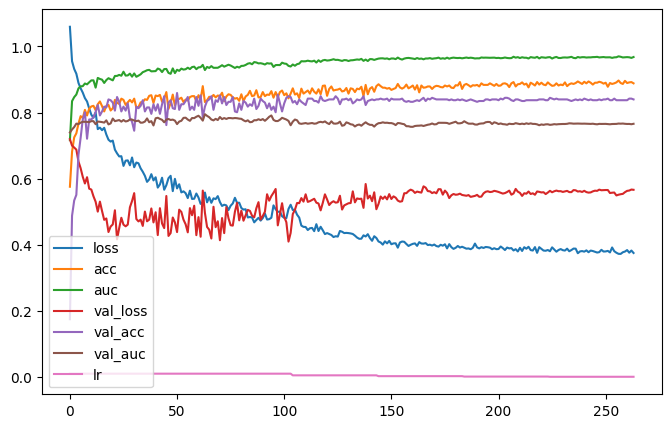

In [365]:
pd.DataFrame(history.history).plot(figsize = (8, 5))
plt.show()

**TODO:** Visualize layer output to debug model performance (see [reference](https://www.kaggle.com/code/kirillka95/keras-nn-layer-activations-ensemble))

### 3.2.2. Model Prediction

In [354]:
y_pred = model_ensemble.predict(x_test)

df_pred = y_test.copy()
df_pred['EmployeeId'] = df.loc[df['IsTest'] == 1, 'EmployeeId']
df_pred['Pred_Percent'] = y_pred * 100

# If more than 50% chance, it's most likely attrition = true
df_pred.loc[df_pred['Pred_Percent'] > 50, 'Pred_Attrition'] = 1
df_pred.loc[df_pred['Pred_Percent'] <= 50, 'Pred_Attrition'] = 0

# https://stackoverflow.com/a/71797755
df_pred['Pred_IsTrue'] = df_pred['Attrition'] == df_pred['Pred_Attrition']

df_pred['Pred_Attrition'] = df_pred['Pred_Attrition'].astype('int')
df_pred = df_pred[['EmployeeId', 'Attrition', 'Pred_Attrition', 'Pred_Percent', 'Pred_IsTrue']]
df_pred.sort_values('Attrition')

13/13 [==============================] - 0s 2ms/step


,EmployeeId,Attrition,Pred_Attrition,Pred_Percent,Pred_IsTrue
0,1,0,0,36.281128,True
953,954,0,0,4.578981,True
952,953,0,0,29.752460,True
949,950,0,0,0.921624,True
945,946,0,0,5.964939,True
...,...,...,...,...,...
547,548,1,0,36.832790,False
1103,1104,1,1,97.859238,True
540,541,1,1,92.330963,True
864,865,1,1,77.393311,True


In [355]:
print(df_pred['Attrition'].value_counts(), '\n')
print(df_pred['Pred_IsTrue'].value_counts())

Attrition
0    354
1     58
Name: count, dtype: int64 

Pred_IsTrue
True     337
False     75
Name: count, dtype: int64


Check F1 score for both attrition 0 and 1 (usually score will be quite bad on minority class)

In [360]:
print(classification_report(df_pred['Attrition'], df_pred['Pred_Attrition']))
print('Confusion matrix:\n', confusion_matrix(df_pred['Attrition'], df_pred['Pred_Attrition']))

              precision    recall  f1-score   support

           0       0.94      0.84      0.89       354
           1       0.41      0.69      0.52        58

    accuracy                           0.82       412
   macro avg       0.68      0.76      0.70       412
weighted avg       0.87      0.82      0.84       412

Confusion matrix:
 [[297  57]
 [ 18  40]]


## Misc

Changelog:
- v1: Initial
- v2: Switch from decision tree to neural network. Around 80-90% accuracy but bad F1 score for attrition = true (0.51)
- v3: Use SMOTE, F1 score varies but generally worse than without using it. Also, SMOTE random seed doesn't work correctly
- v4: Remove SMOTE. Changed label encoder to target encoder, added feature selection using Pearson method. F1 score doesn't seem to improve much even after following this [reference](https://www.kaggle.com/code/tanmay111999/hr-analytics-data-leakage-eda-f1-score-80) (reference has data leakage)
- v5: Use model ensembling (3 NN models), F1 score is still the same but prediction is somewhat better (more true positives)
- v6: Used label encoder again before uploading data to Supabase (it will still be encoded using target encoder, but in later steps)

Reference and/or todo list:
- https://www.kaggle.com/competitions/playground-series-s3e3 (main competition)
- https://www.kaggle.com/competitions/cat-in-the-dat-ii (categorical feature encoding)
- https://www.kaggle.com/code/tanmay111999/hr-analytics-data-leakage-eda-f1-score-80 (good EDA, recommended)
- https://www.kaggle.com/code/kirillka95/keras-nn-layer-activations-ensemble (ensemble NN, NN visualization, recommended)
- https://www.kaggle.com/code/robertobonilla/explained-100-advanced-classification-beginners (multiple normalization/pre-processing)
- https://www.kaggle.com/code/ashishkumarak/employee-retention-workforce-reduction-prediction (calculating feature importance NN)
- https://www.kaggle.com/code/samuelcortinhas/ps-s3e3-hill-climbing-like-a-gm (hill climbing)
- https://www.kaggle.com/code/zuberrr/feature-engineering-w-xgboost-87-auc-in-10-mins (feature engineering)
- https://www.kaggle.com/code/cv13j0/pss-3-episode-3-lama (feature engineering)
- https://www.kaggle.com/code/kirillka95/ps-s03e03-eda-16-models-test-0-94 (ensemble + model test)
- https://www.kaggle.com/code/chunweishen/ps-s03e03-ensembling (ensemble + feature importance)